<a href="https://colab.research.google.com/github/mosemb/AdvancedML/blob/main/RbfKernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import math

In [2]:
from google.colab import files
uploaded = files.upload()

Saving AML_exam.txt to AML_exam.txt


In [3]:
df = pd.read_csv('AML_exam.txt',sep='\t',header=(0))

In [4]:
df.drop('Unnamed: 0',inplace=True,axis=1)

In [5]:
df['datetime']=pd.to_datetime(df['datetime'],format='%Y%m%d%H%M%S')

In [6]:
df.set_index('datetime')

,speed
datetime,
2015-01-01 00:00:00,NaN
2015-01-01 01:00:00,NaN
2015-01-01 02:00:00,NaN
2015-01-01 03:00:00,NaN
2015-01-01 04:00:00,NaN
...,...
2018-12-31 19:00:00,2.148734
2018-12-31 20:00:00,1.608662
2018-12-31 21:00:00,0.647012


In [7]:
df.isnull().sum()

datetime        0
speed       16515
dtype: int64

In [8]:
df.loc[(df.datetime <= '2015-01-01 00:00:00') | (df.datetime >= '2015-01-31 00:00:00')]

,datetime,speed
0,2015-01-01 00:00:00,NaN
720,2015-01-31 00:00:00,NaN
721,2015-01-31 01:00:00,NaN
722,2015-01-31 02:00:00,NaN
723,2015-01-31 03:00:00,NaN
...,...,...
35059,2018-12-31 19:00:00,2.148734
35060,2018-12-31 20:00:00,1.608662
35061,2018-12-31 21:00:00,0.647012
35062,2018-12-31 22:00:00,1.206987


In [9]:
df_2015 = df[(df['datetime'] > '2014-12-31') & (df['datetime'] < '2016-01-01')]

In [10]:
len(df_2015)

8760

In [11]:
df_2015.speed.isnull().sum()

8760

In [14]:
#Drop years values in this range for the year 2015
df=df[~df.datetime.isin(df_2015.datetime)]

In [15]:
df_2016 = df[(df['datetime'] > '2015-12-31') & (df['datetime'] < '2017-01-01')&(df.speed.isnull()==True)]

In [16]:
#Drop years values in this range for the year 2015
df=df[~df.datetime.isin(df_2016.datetime)]

In [17]:
df.isnull().sum()

datetime     0
speed       15
dtype: int64

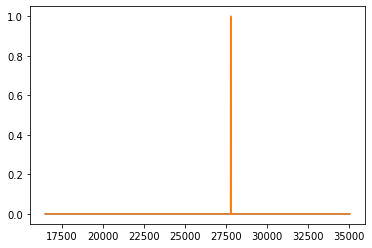

In [18]:
plt.plot(df.isnull())

In [19]:
#Fill the rest of the null values with the mean
df.fillna(df.speed.mean(),inplace=True)

In [20]:
#Check for more null values
df.isnull().sum()

datetime    0
speed       0
dtype: int64

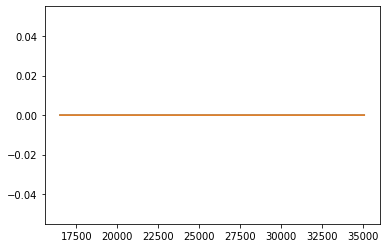

In [21]:
#All null values have been dealt with.
plt.plot(df.isnull())

In [22]:
data = df['speed'].values

In [23]:
train_size = int(len(data)*0.7)
test_size = int(len(data)*0.3)

X_train = data[0:train_size]
X_test = data[train_size:len(data)]

In [24]:
#Feature extraction
def sequences(data, combination=1):
    x = []
    y = []

    for i in range(len(data)-combination-1):
        window = data[i:(i+combination)]
        x.append(window)
        y.append(data[i+combination])
        
    return np.array(x),np.array(y)

combination= 24  # Number of time steps to look back 

X_train, Y_train = sequences(X_train, combination)
X_test, Y_test = sequences(X_test, combination)
#X, Y = sequences(filter_d, combination)

In [26]:
# Parameters for grid search cv
param_grid = {"alpha": np.logspace(0.0001,10,10),
              "kernel":['rbf'],
              "gamma":np.logspace(0.0001,10,10) #[10,1e0, 1e-1, 1e-2, 1e-3,1e-4],
              #"degree":[3,4,5],
              #"coef0":[2,3,4] 
              }

tscv = TimeSeriesSplit(n_splits=5)
kr = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=tscv,return_train_score=True)

In [27]:
score = []
datasize = []
alphas = []
gammas = []
X_tr_s = []
X_te_s = []
Y_pre_tr = []
Y_pre_te = []


for i in np.linspace(0.1,1,10):
  data = df['speed'].values
  dat = data[:int(data.shape[0]*i)]
  print(i,dat.shape)

  train_size = int(len(dat)*0.7)
  test_size = int(len(dat)*0.3)
  
  X_train = dat[0:train_size]
  X_test = dat[train_size:len(dat)]

  X_train, Y_train = sequences(X_train, combination)
  X_test, Y_test = sequences(X_test, combination)

  train = kr.fit(X_train,Y_train)
  al = train.best_score_
  score.append(al)
  datasize.append(i)
  alphas.append(train.best_params_['alpha'])
  gammas.append(train.best_params_['gamma'])

  X_ = train.score(X_train,Y_train)
  X_tr_s.append(X_)
  Xte_= train.score(X_test,Y_test)
  X_te_s.append(Xte_)

  Y_pred_train = train.predict(X_train)

  #Y_pre_tr = []
  #Y_pre_te = []
  Y_pred_test = train.predict(X_test)



  trainScore = math.sqrt(mean_squared_error(Y_train,Y_pred_train ))
  Y_pre_tr.append(trainScore)

  testScore = math.sqrt(mean_squared_error(Y_test, Y_pred_test))
  Y_pre_te.append(testScore)
  
  import warnings
  warnings.simplefilter('ignore')

KeyboardInterrupt: ignored

In [31]:
np.linspace(0.05,1,15)

array([0.05      , 0.11785714, 0.18571429, 0.25357143, 0.32142857,
       0.38928571, 0.45714286, 0.525     , 0.59285714, 0.66071429,
       0.72857143, 0.79642857, 0.86428571, 0.93214286, 1.        ])